In [1]:
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from typing import Counter
import string
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('train.csv')
features = ["id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## Data cleaning

In [3]:
lemmatizer = WordNetLemmatizer()

nlp = spacy.load('en_core_web_sm')

def remove_upper(text):
    return text.lower()

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_username(text):
    words = text.split()
    username = re.compile(r'^[a-zA-Z0-9]+[?=.*\d]$')

    def remove_username_from_word(word):
        if re.match(username, word):
            return ""
        else:
            return word

    words = text.split()
    tokens = [remove_username_from_word(word) for word in words]
    text = " ".join(tokens)

    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    lem_text = " ".join(lemmas)
    return lem_text

def clean_text(text):

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]

    # Rimozione di numeri (puoi personalizzare questa parte)
    tokens = [token for token in tokens if not token.isdigit()]

    # Unisci i token in una stringa
    clean_text = ' '.join(tokens)

    return clean_text

def pre_processing_data(df): 
    df['comment_text']=df['comment_text'].apply(lambda x : remove_upper(x))
    df['comment_text']=df['comment_text'].apply(lambda x : remove_URL(x))
    df['comment_text']=df['comment_text'].apply(lambda x : remove_username(x))
    df['comment_text']=df['comment_text'].apply(lambda x : remove_html(x))
    df['comment_text']=df['comment_text'].apply(lambda x: remove_emoji(x))
    df['comment_text']=df['comment_text'].apply(lambda x: lemmatize_text(x))
    df['comment_text']=df['comment_text'].apply(lambda x : remove_punct(x))
    return df

df_cleaned = pre_processing_data(df)
df_cleaned.to_csv("cleaned_data_train.csv",index=False)
df_cleaned

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he match this background colour i m seem...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit it s ju...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i ca nt make any real suggestion on impr...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my any chance you remember what ...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when ...,0,0,0,0,0,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ho...,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer umm there no actual article for prost...,0,0,0,0,0,0
159569,fff125370e4aaaf3,and it look like it wa actually you who put on...,0,0,0,0,0,0


In [4]:
en_stopwords = stopwords.words('English')
lemmatizer = WordNetLemmatizer()
bow_model = CountVectorizer(
    lowercase=True,
    stop_words=en_stopwords,
    analyzer='word',
    ngram_range=(1 , 1) # unigram extraction
)
text_columns = df.iloc[:2, 1]
X = bow_model.fit_transform(text_columns)
numeric_columns = df.iloc[:2, 2:]
# Concatena le matrici
X_combined = np.concatenate([X.toarray(), numeric_columns], axis=1)

In [5]:
X_combined = pd.DataFrame(X_combined)
X_combined.head()
df_bow = bow_model.fit_transform(df.iloc[:,1])


KeyboardInterrupt: 

In [ ]:
df_negative = df[(df['toxic'] > 0) | (df['severe_toxic'] > 0) | (df['obscene'] > 0) | (df['threat']> 0) | (df['insult'] > 0) | (df['identity_hate'] > 0)]

## Word Cloud

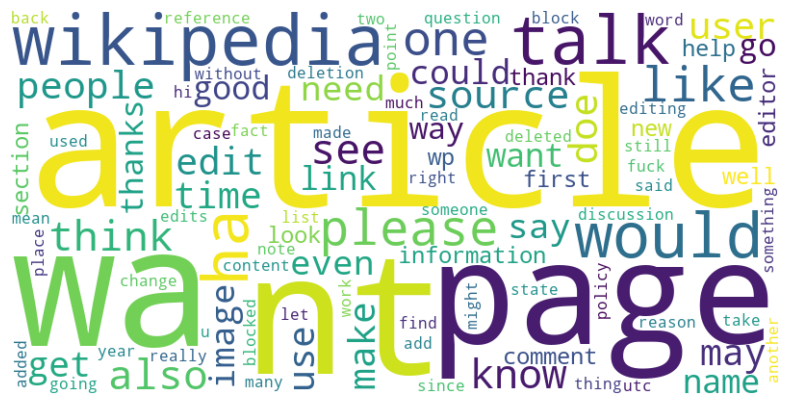

In [ ]:
def crea_wordcloud(testo):
    # Pulizia del testo
    testo = ' '.join(testo.astype(str))
    testo = testo.lower()
    testo = ''.join(c for c in testo if c.isalnum() or c.isspace())

    # Tokenizzazione
    parole = testo.split()

    # Rimozione delle stop word
    stop_words = set(stopwords.words('english'))
    parole = [parola for parola in parole if parola not in stop_words]

    # Calcolo della frequenza
    conteggio_parole = Counter(parole)

    # Selezione delle prime 100 parole
    prime_100 = conteggio_parole.most_common(100)

    # Creazione della word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(prime_100))

    # Visualizzazione
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

crea_wordcloud(df['comment_text'])

In [ ]:
sentences = df_cleaned["comment_text"].fillna("DUMMY_VALUE").values

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


print("Max sequence length:", max(len(s) for s in sequences))
print("Min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

word2idx = tokenizer.word_index
print('Unique words: %s' % len(word2idx))

Max sequence length: 1354
Min sequence length: 0
median sequence length: 32
max word index: 19999
Unique words: 205268


In [ ]:
import seaborn as sns
def distribution_length(df, sequences):
    df['num_words'] = 0  

    for i, seq in enumerate(sequences):
        num_words = len(seq)
        df.loc[i, 'num_words'] = num_words

    return df

def visualizza_distribuzione(df, nome_colonna):

    plt.figure(figsize=(10, 6))

    sns.histplot(df[nome_colonna], kde=True, bins=40)
    plt.title(f'Dataset Cleaned distribuition')
    plt.xlabel(nome_colonna)
    plt.ylabel('Frequenza')
    plt.show()


    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[nome_colonna])
    plt.title(f'Box plot di {nome_colonna}')
    plt.xlabel(nome_colonna)
    plt.show()

    print(df[nome_colonna].describe())

d = distribution_length(df, sequences)
visualizza_distribuzione(d, 'num_words')

NameError: name 'df' is not defined

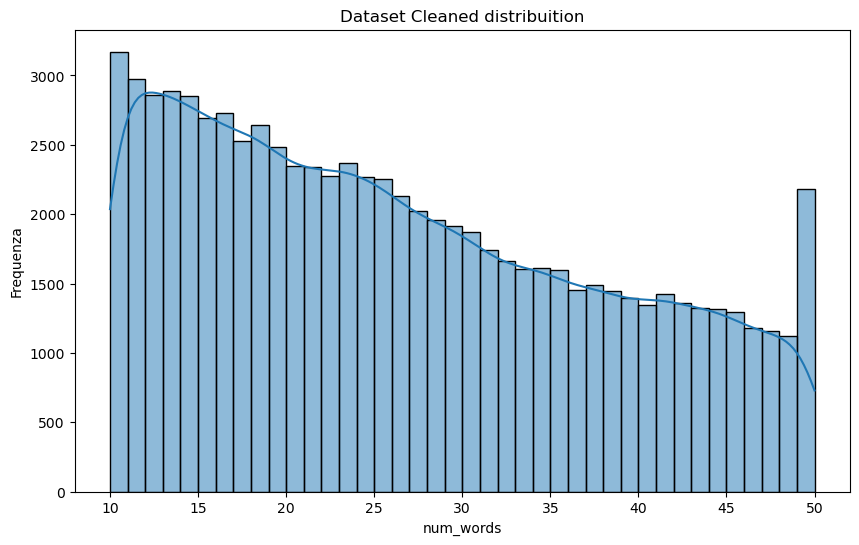

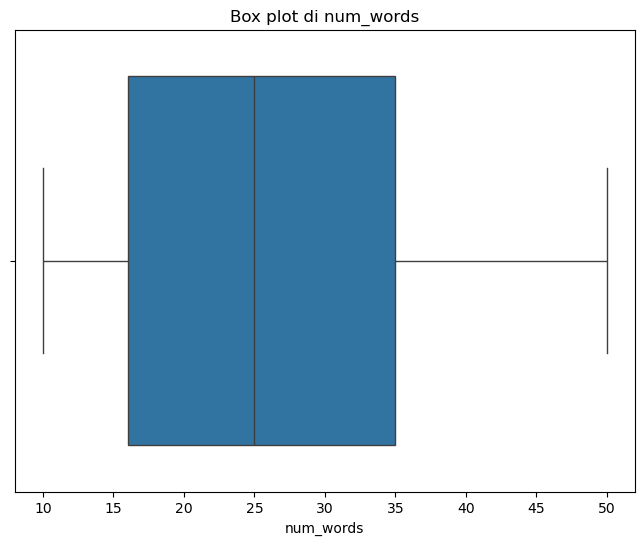

count    79291.000000
mean        26.316518
std         11.462634
min         10.000000
25%         16.000000
50%         25.000000
75%         35.000000
max         50.000000
Name: num_words, dtype: float64


In [ ]:

d = d.loc[d['num_words'] >= 10]
d = d.loc[d['num_words'] <= 50]
visualizza_distribuzione(d,'num_words')